## Импорт библиотек

In [ ]:
# import os                           # Пути и директории в любой оперционной системе
# import random                       # Случайные числа в стандартном Python
# import pandas as pd                 # Pandas для работы с таблицами данных
# import numpy as np
# import matplotlib.pyplot as plt

# from skimage import io, color       # Для импотра и экспорта изображений
# import cv2                          # OpenCV
# from PIL import Image               # Python Imaging Library

# import torch
# import torch.nn as nn               # Модуль PyTorch для слоёв нейронных сетей
# import torch.optim as optim         # Модуль методов оптимизации из библиотеки PyTorch
# import torch.nn.functional as F     # модуль, который хранит в себе базовые операции в нейронных сетях, например выставление отступа для входного изображения, пулинги, и т.д.
# import torchvision                  # Библиотека готовых решений для CV
# from torchvision import transforms  # Модуль PyTorch для предобработки изображений
# from torch.utils.data import DataLoader, Dataset        # Полезный модуль для загрузки данных батчами

# from tqdm.notebook import tqdm      # Прогресс-бар

## Загрузка данных

В данной работе будет показано построение свёрточной нейронной сети для задачи классификации мест на основе датасета, ссылка на который указана ниже:

https://www.kaggle.com/nitishabharathi/scene-classification

Загрузка этого датасета с kaggle выглядит следующим образом. Для этого необходимо из командной строки вызвать утилиту kaggle с опцией datasets download и в качестве аргумента указать dataset с которым вы хотите работать.

## Описание архитектуры

Начало построения глубокой сверточной модели по архитектуре AlexNet

In [5]:
# # Начальные значения генераторов случайных чисел
# seed = 3
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True

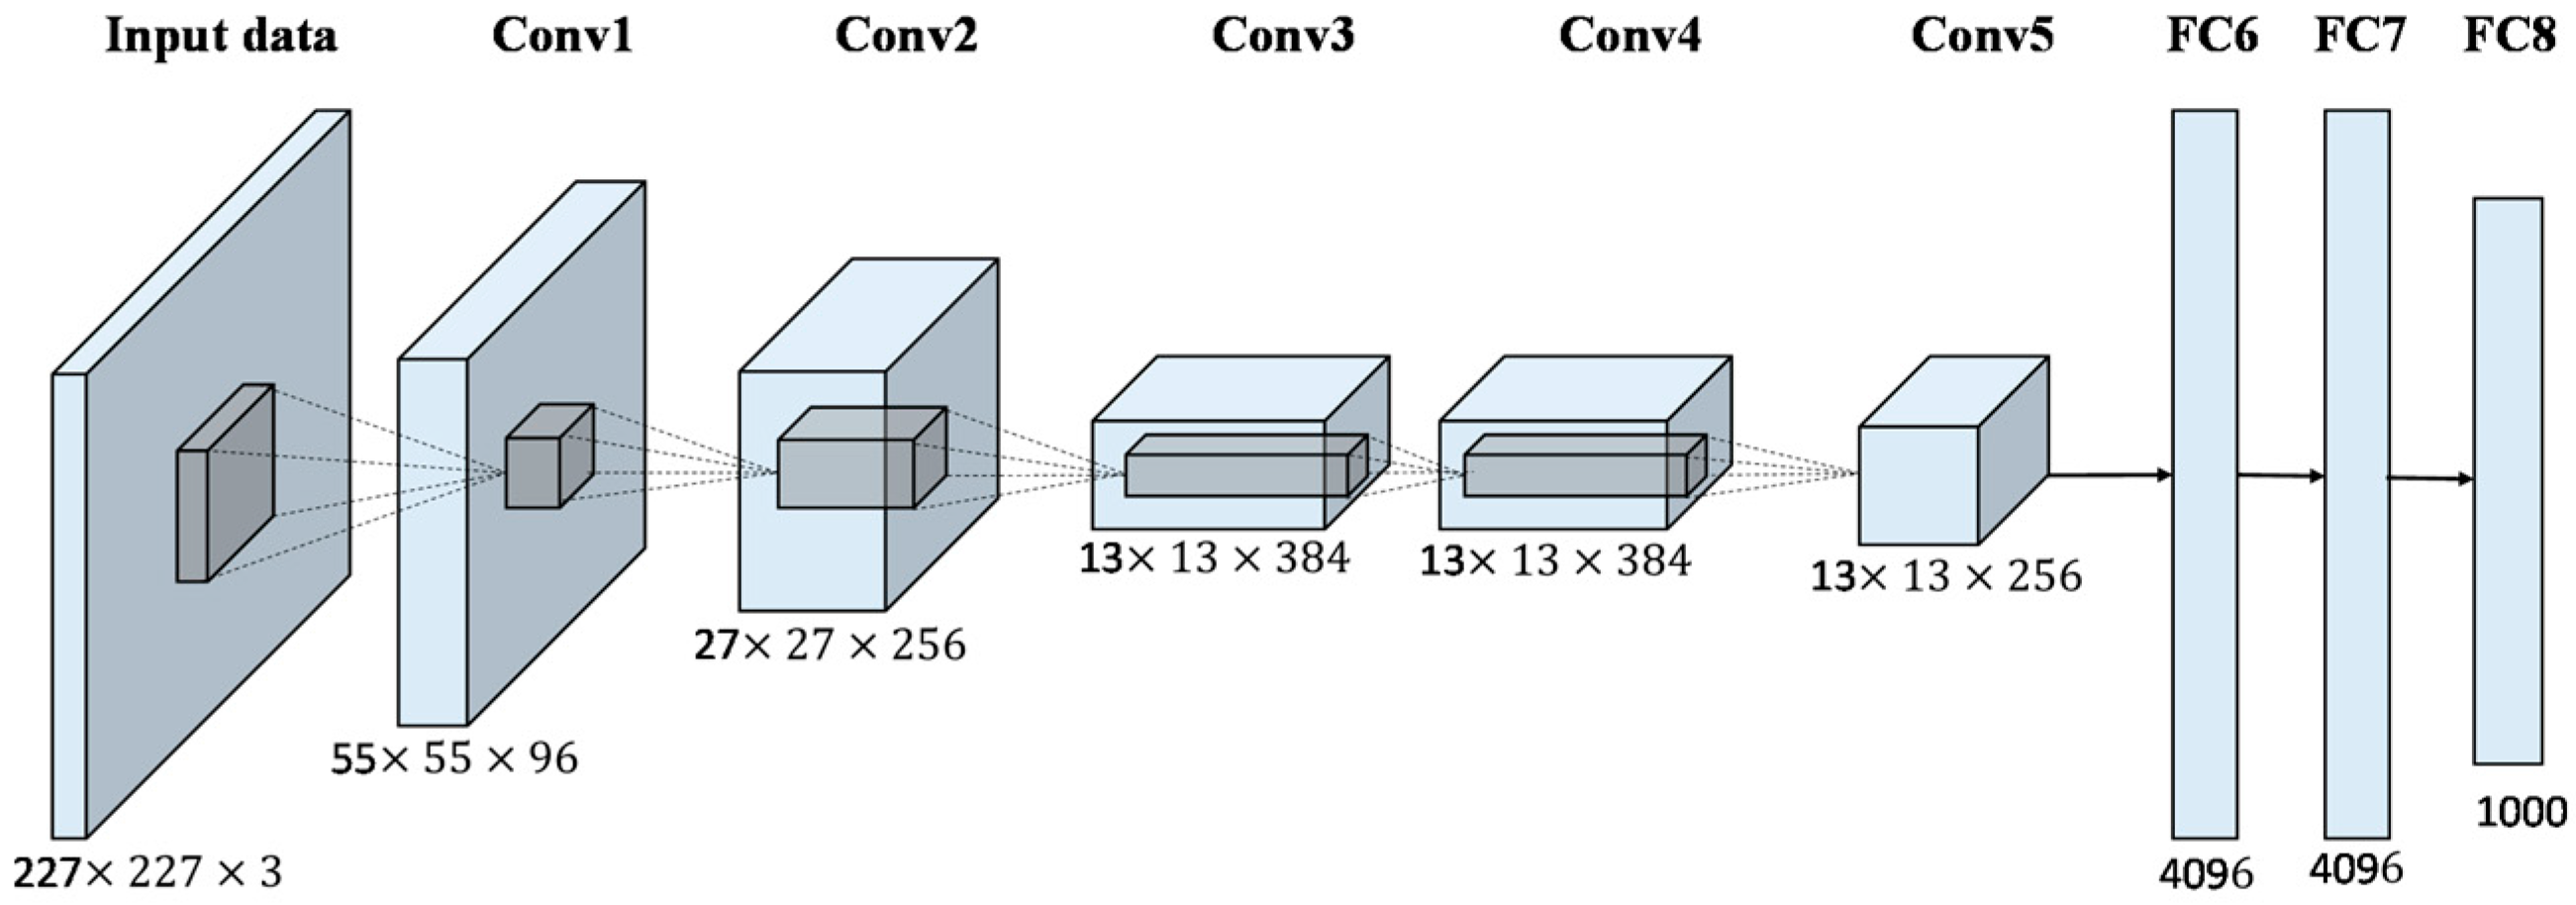

Оценивать вероятность наблюдать класс на изображении будем при помощи Softmax

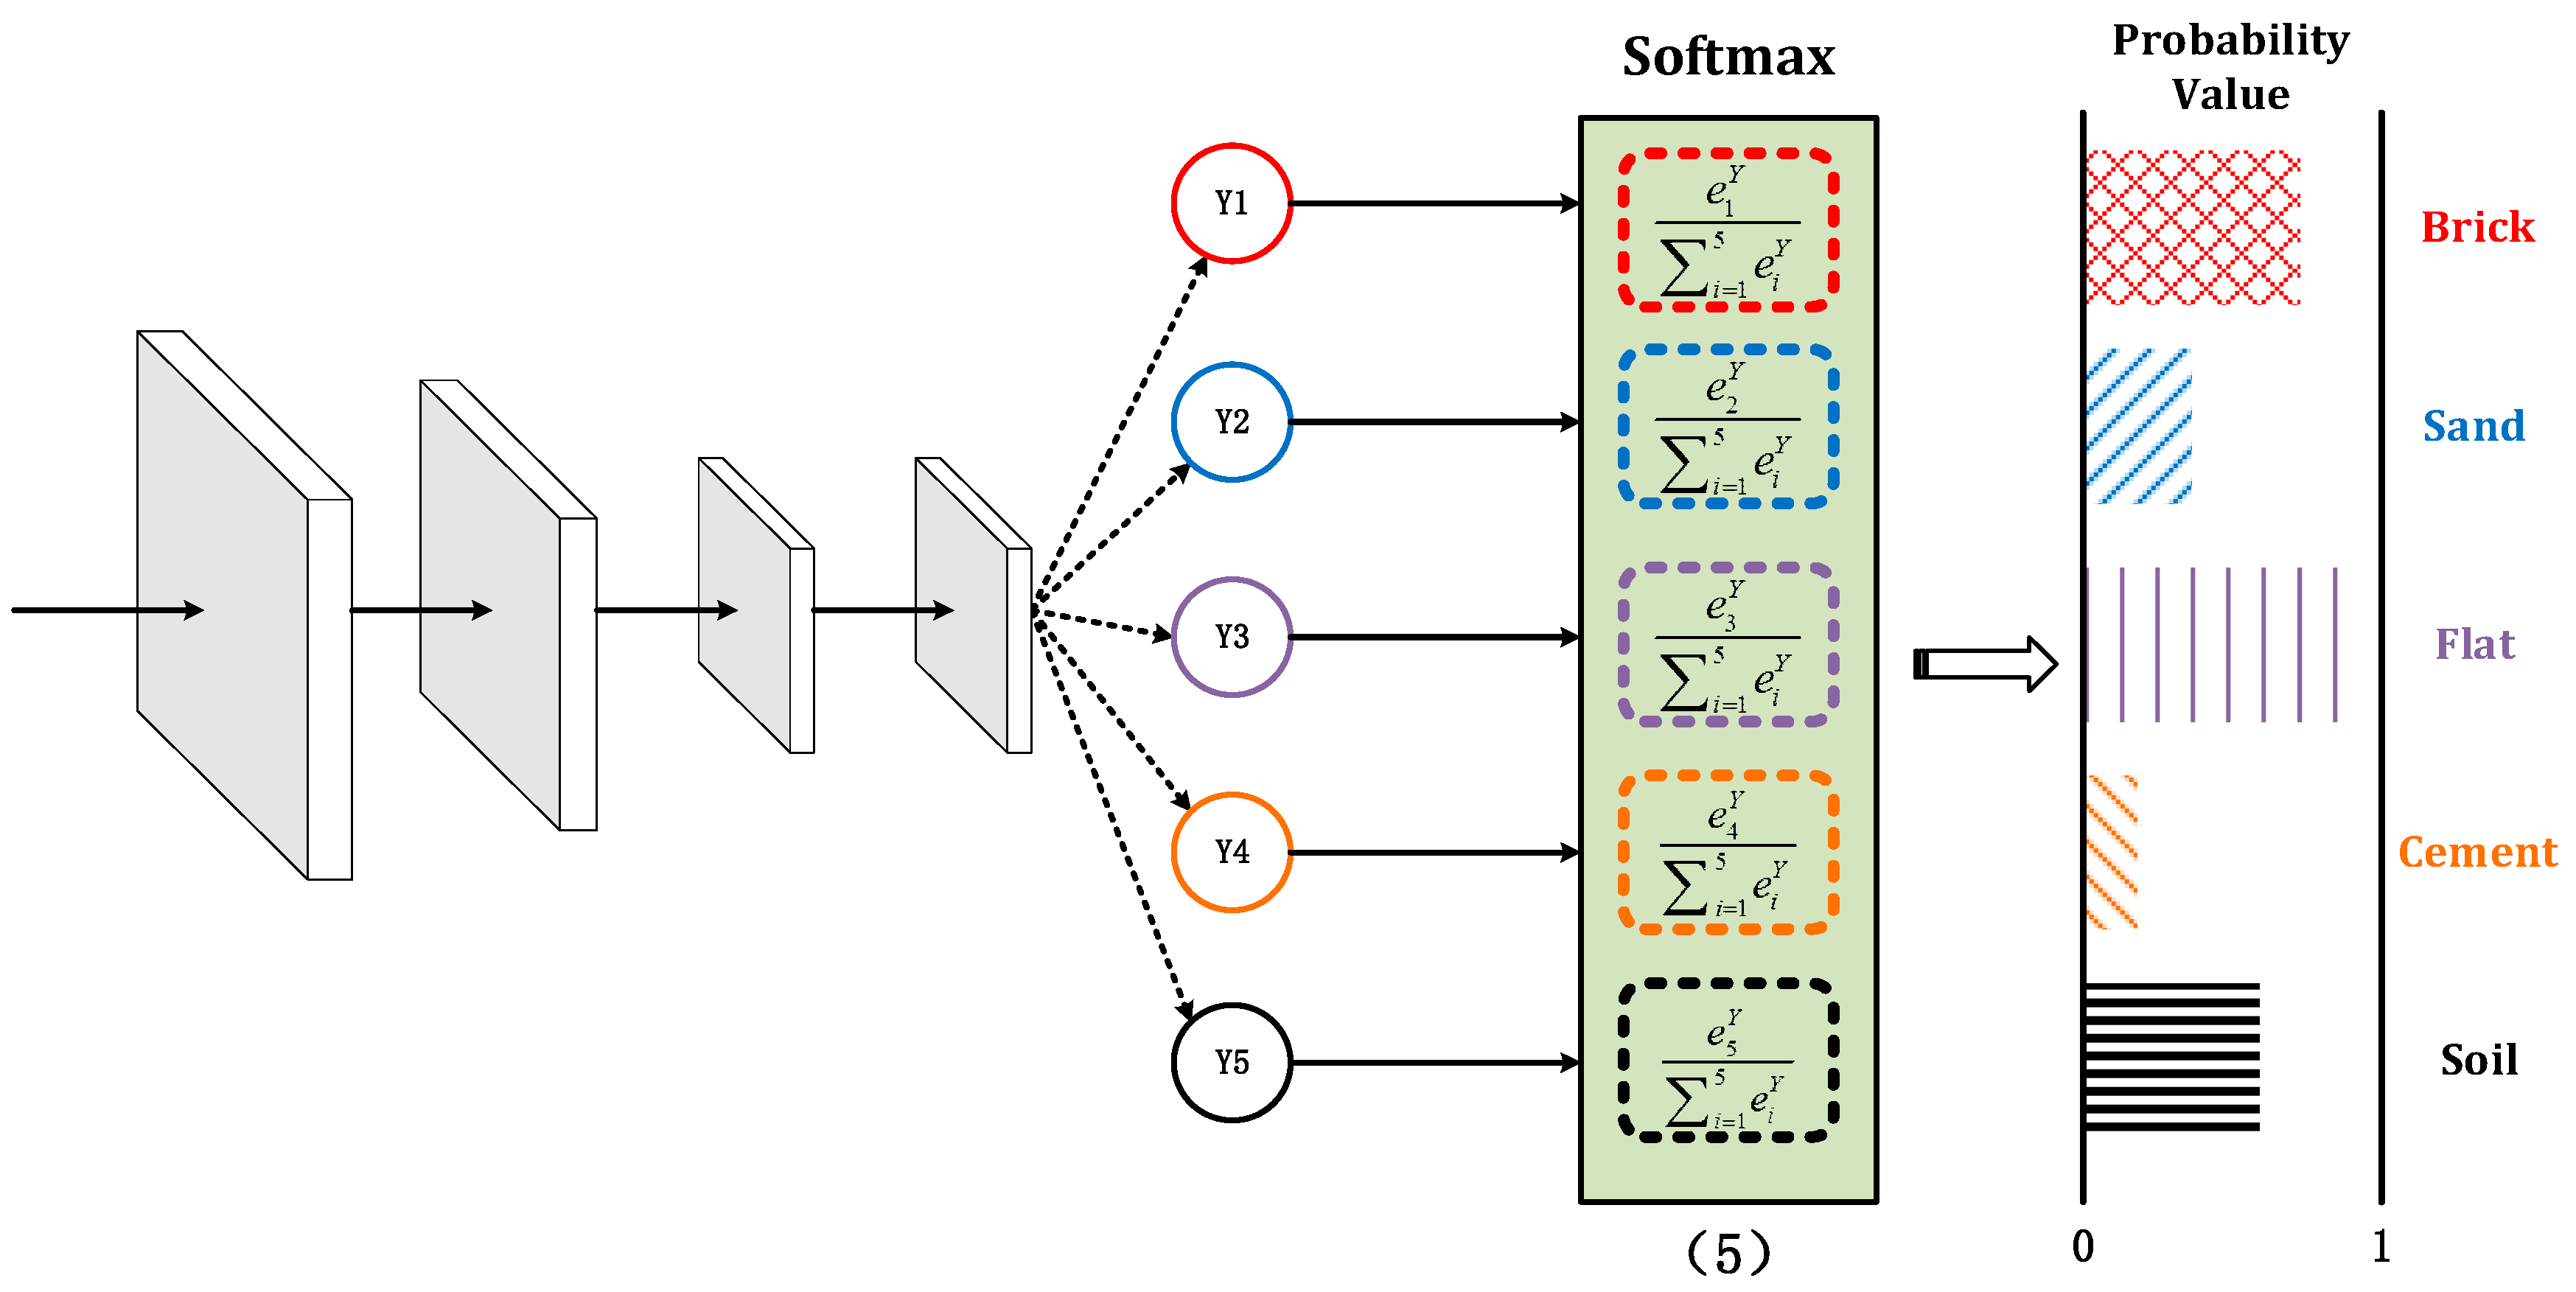

## Перенос архитектуры на PyTorch

In [1]:
# # Ожидается, что входной тензор будет иметь размеры (batch_size, 3, 224, 224)
# class Alexnet(nn.Module):
#     def __init__(self):

#         super(Alexnet, self).__init__()

#         # Свёрточные слои нейронной сети
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2)
#         self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
#         self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
#         self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(in_features=256 * 6 * 6, out_features=4096)
#         self.fc2 = nn.Linear(in_features=4096, out_features=4096)
#         self.fc3 = nn.Linear(in_features=4096, out_features=6)

#         # Действия между слоями в нейронной сети
#         self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)   # Макспулинг 3х3 с шагом 2
#         self.relu = nn.ReLU()                                   # функция активации ReLU
#         # Этот слой помогает нам избежать вычисления размера выходной карты признаков при загрузке в линейный слой в PyTorch
#         self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(6, 6))

#         # Реализация из библиотеки PyTorch
#         self.norm = nn.LocalResponseNorm(size = 5, alpha = 1e-4, beta = 0.75, k = 1)
#         # Наша реализация
#         #self.norm = LocalResponseNormalization(neighbourhood_length=5, normalisation_const_alpha=1e-4, contrast_const_beta=0.75, noise_k=1.0)

#         self.dropout = nn.Dropout()                             # Слой регуляризации перед выходом на полносвязный слой нейронной сети

#     # Алгоритм прямого распространения информации
#     def forward(self, x):
#         # Первый свёрточный слой
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.norm(x)
#         x = self.max_pool(x)

#         # Второй свёрточный слой
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.norm(x)
#         x = self.max_pool(x)

#         # Две последовательные свёртки 3х3 без пулинга
#         # третий свёрточный слой
#         x = self.conv3(x)
#         x = self.relu(x)
#         # четвёртый свёрточный слой
#         x = self.conv4(x)
#         x = self.relu(x)

#         # Пятый слой с adatpive pool
#         x = self.conv5(x)
#         x = self.relu(x)
#         x = self.norm(x)
#         x = self.adaptive_pool(x)

#         # Сплющивание данных перед подачей в полносвязный выходной слой
#         x = torch.flatten(x, 1)

#         # Полносвязная нейронная сеть на выходе
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x

## Класс Dataset для удобной загрузки данных из диска¶

Настроим собственный набор данных для нашего набора данных классификации сцен.

In [2]:
# class SceneDataset(Dataset):
#     def __init__(self, annotations_csv, root_dir, transform=None):
#         # Подписи к картинкам, какая картинка что обозначает
#         # Поле класса, которе будет хранить csv табличку с ассоциативным списком
#         self.annotations = pd.read_csv(annotations_csv)
#         # Путь к директории с тренировочными картинками
#         self.root_dir = root_dir
#         # Операция преобразования картинок датасета для того, чтобы поместить их в нейронную сеть, так как она требует на входе картинок 224х224
#         self.transform = transform

#     def __len__(self):
#         return len(self.annotations)

#     # Операция взятия пути к файлу, чтения и возврата ассоциативного списка из изображения и иназвания сцены
#     # Переопредение стандартной операции взятия из объекта его содержимого под каким-то номером
#     def __getitem__(self, index):
#         # os.path.join соединяет строки между собой, образуя путь к файлу в той ОС, в которой мы работаем
#         img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
#         # io.imread(img_path) по ранее созданному пути к файлу картинки, читаем картинку в python в виде числового тензора
#         image = io.imread(img_path)
#         # Подпись к картинке также переводим в числовой тензор
#         label = torch.tensor(int(self.annotations.iloc[index, 1]))
#         # Если есть трансформация входного изображения к нужным размерам, то применяем её к картинке
#         if self.transform:
#             image = self.transform(image)
#         return [image, label]

## Проверка точности работы модели

Специальная функция для проверки точности на тренировочной выборке и тестовой выборке

In [ ]:
# def check_accuracy(loader, model):
#     num_correct = 0
#     num_samples = 0
#     # Не забудьте переключиться в режим оценки!
#     model.eval()

#     with torch.no_grad():                   # Не производить обратного подсчёта градиента, чтобы сеть не училась в процессе проверки
#         for data, targets in tqdm(loader):  # tqdm() это прогресс-бар, можно и без него обойтись, удалив его
#             data = data.to(device)          # Перевод данных на ранее объявленное железо для просчёта всех вычислений
#             targets = targets.to(device)    # Перевод целевых данных также на карточку, чтобы ошибки считались на карте
#             scores = model(data)            # Прямое распространение информации по сети forwardpass
#             _, predictions = scores.max(1)  # Возвращаем позицию наибольшего выхода из сети
#             num_correct += (predictions == targets).sum()       # Считаем количество правильных ответов
#             num_samples += predictions.size(0)                  # Количество исходных данных по просчёту процента
#         print("Correct: {}, Total: {}, Accuracy: {}".format(num_correct, num_samples, int(num_correct) / int(num_samples)))
#     # Не забудьте вернуться к model.train(), так как вы закончили с оценкой
#     model.train()
#     return (int(num_correct) / int(num_samples))

## Настройка и определение гиперпараметров обучения

In [ ]:
# # Можно поиграться здесь с параметрами обучения
# LEARNING_RATE = 0.001        # Скорость обучения
# BATCH_SIZE = 20              # Размер подвыборки на которой будет происходить градиентный шаг
# EPOCHS = 20                  # Количество полных проходов по всем картинкам из тренировочного набора при обучении нейронной сети
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

# # Трансформации медиафайлов из библиотеки torchvision.transforms https://pytorch.org/docs/stable/torchvision/transforms.html
# # Мы будем как бы прокидывать применение этой функции внутрь функции объявления датасета
# transform_img = transforms.Compose([
#     transforms.ToPILImage(),            # Python Imaging Library
#     transforms.Resize((224, 224)),      # Принудительное сжатие и интерполяция
#     transforms.ToTensor()               # Трансформация к тензору исходных данных
# ])

# # Инициализация созданного класса dataset
# data = SceneDataset(annotations_csv="/kaggle/input/scene-classification/train-scene classification/train.csv",
#                         root_dir="/kaggle/input/scene-classification/train-scene classification/train",
#                         transform = transform_img)

# train_data, test_data = torch.utils.data.random_split(data, [12034, 5000])      # попил на 12034/5000

# # Мы не хотим выгружать в Python все картинки сразу, это очень затратно по памяти, поэтому лучше выбгружать картинки по требованию
# # этой функции берётся стандартная функция для выбора элемента объекта по индексу, следовательно вызывается __getitem__
# train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

# # Объявление объекта созданной сети
# alexnet = Alexnet()
# # Перевод на видеокарту
# alexnet.to(device)
# # loss
# criterion = nn.CrossEntropyLoss()
# # оптимизатор Adam
# optimizer = optim.Adam(alexnet.parameters(), lr=LEARNING_RATE)

## Код для обучения весов глубокой свёрточной сети

In [3]:
# data, targets = next(iter(train_loader))
# losses_global = []
# losses_mean_epochs = []
# #accuracy_train = []
# accuracy_test = []
# for epoch in tqdm(range(EPOCHS)):
#     losses = []
#     with tqdm(total=len(train_loader)) as pbar:
#         for batch_idx, (data, targets) in enumerate(train_loader):     # Пара ключ-значения https://younglinux.info/python/feature/enumerate
#             optimizer.zero_grad()
#             data = data.to(device=device)
#             targets = targets.to(device=device)

#             scores = alexnet(data)
#             loss = criterion(scores, targets)

#             losses.append(loss)
#             #losses_global.append(loss)

#             # backprop
#             loss.backward()
#             optimizer.step()
# #                 print(loss.item())
#             pbar.update(1)
#     print("Cost at epoch {} is {}".format(epoch, sum(losses) / len(losses)))
#     losses_mean_epochs.append(sum(losses) / len(losses))
#     #r = check_accuracy(train_loader, alexnet)
#     t = check_accuracy(test_loader, alexnet)
#     accuracy_test.append(t)
#     accuracy_train.append(t)

## Проверка работы сети

In [4]:
# def show_image_and_prediction(img_path):
#     idx2label = {0: "Buildings",
#                  1: "Forests",
#                  2: "Mountains",
#                  3: "Glacier",
#                  4: "Sea",
#                  5: "Street"}
#     img = io.imread(img_path)
#     transformed_img = transform_img(img)
#     out = alexnet(transformed_img.unsqueeze(0).to(device=device))
#     _, pred = out.max(1)
#     plt.imshow(img)
#     plt.show()
#     print("Alexnet thinks this scence contains: {}".format(idx2label[pred.item()]))

In [ ]:
# show_image_and_prediction("/kaggle/input/scene-classification/train-scene classification/train/10010.jpg")